# Calculating the Scalp Coupling Index

This notebook calculates the Scalp Coupling Index[1] metric for assessing the signal quality of a recording.


[1] L. Pollonini, C. Olds, H. Abaya, H. Bortfeld, M. S. Beauchamp, and J. S. Oghalai, “Auditory cortex activation to natural speech and simulated cochlear implant speech measured with functional near-infrared spectroscopy,” Hearing Research, vol. 309, pp. 84–93, Mar. 2014, doi: 10.1016/j.heares.2013.11.007.


In [14]:
import cedalion
import cedalion.nirs
import cedalion.datasets
import numpy as np
import xarray as xr
import matplotlib.pyplot as p
from matplotlib.colors import LinearSegmentedColormap
np.float_ = np.float64


xr.set_options(display_expand_data=False)

### Loading raw CW-NIRS data from a SNIRF file

This notebook uses a finger-tapping dataset in BIDS layout provided by Rob Luke. Download it [here](https://github.com/rob-luke/BIDS-NIRS-Tapping) and point the variable `DATADIR` to its location.

In [15]:
rec = cedalion.datasets.get_fingertapping()
rec.stim.cd.rename_events(
    {
        "1.0": "control",
        "2.0": "Tapping/Left",
        "3.0": "Tapping/Right",
    }
)

In [16]:
rec["amp"]

Magnitude,[[[0.0913686 0.0909875 0.0910225 ... 0.0941083 0.0940129 0.0944882] [0.1856806 0.186377 0.1836514 ... 0.1856486 0.1850836 0.1842172]] [[0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.6354927 0.637668 0.6298023 ... 0.6072068 0.6087293 0.6091066]] [[0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] [0.2755033 0.2761615 0.2727006 ... 0.2911952 0.2900544 0.2909847]] ... [[0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4666358 0.4554404 0.4561614 ... 0.4809749 0.4812827 0.4862896]] [[0.4885007 0.4802285 0.4818338 ... 0.6109142 0.6108118 0.613845] [0.8457658 0.825988 0.8259648 ... 0.975894 0.9756599 0.9826459]] [[0.6304559 0.6284427 0.6287045 ... 0.6810626 0.6809573 0.6818709] [1.2285622 1.2205907 1.2190002 ... 1.2729124 1.2727222 1.2755645]]]
Units,volt


## Calculating the SCI

From the paper:

> Since the LED sources at 760 nm and 850 nm were co-located, an optical channel in good contact with the scalp exhibited a prominent synchronous cardiac pulsation in both photodetected signals. This observation was independent of the
> amplitude of the output voltage of the photodetector, which in turn depends on the inter-distance between sources and detector. For each channel, we filtered both photodetected signals between 0.5 and 2.5 Hz to preserve only the cardiac
> component and normalized the resulting signals to balance any difference between their amplitude. Then, we computed the cross-correlation and we extracted the value at a time lag of 0 to quantify the similarity between the filtered 
> signals. In-phase and counter-phase identical waveforms yielded a zero-lag cross-correlation value of 1 and +1 respectively, whereas a null value derived from totally uncorrelated signals. Therefore, the zero-lag cross-correlation
> between photodetected signals of the same channel was used as a quantitative measure of the signal-to-noise ratio of the channel. We termed this value the scalp coupling index (SCI).


### 0. Utilities

In [17]:
def plot_channel(array, channel, ylabel, xlabel="time", tmin=1000, tmax=1030):
    f, ax = p.subplots(1,1, figsize=(12,4))
    ax.plot(array.time, array.sel(channel=channel, wavelength=760), "r-")
    ax.plot(array.time, array.sel(channel=channel, wavelength=850), "b-")
    p.xlim(tmin, tmax)
    p.xlabel(xlabel)
    p.ylabel(ylabel)

### 1. Bandpass filter to extract the cardiac signal

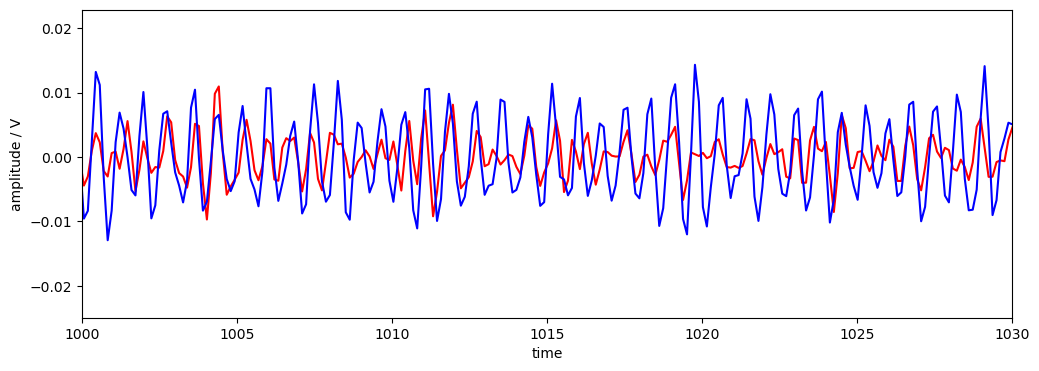

In [18]:
amp_filtered = rec["amp"].cd.freq_filter(0.5, 2.5, butter_order=4)

plot_channel(amp_filtered, "S5D7", "amplitude / V")


### 2. Normalize filtered amplitudes

Subtract the mean and normalize to each channels standard deviation.

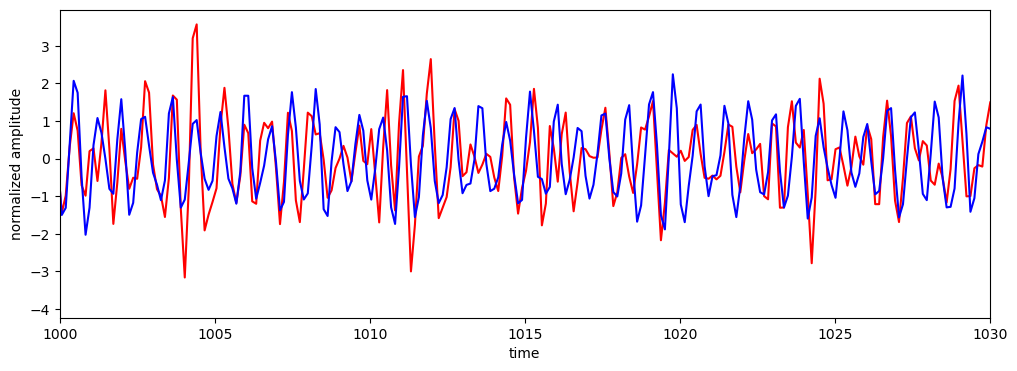

In [19]:
amp_filtered_normed = (amp_filtered - amp_filtered.mean("time")) / amp_filtered.std("time")
#amp_filtered_normed = (amp_filtered - amp_filtered.min("time")) / (amp_filtered.max("time") - amp_filtered.min("time"))

plot_channel(amp_filtered_normed, "S5D7", "normalized amplitude")

### 3. Moving windows

Calculate non-overlapping, moving windows of 5 seconds

In [20]:
window_len_s = 5 # seconds
window_len_samples = int(np.ceil(window_len_s * amp_filtered_normed.cd.sampling_rate))
print(f"At a sampling rate of {amp_filtered_normed.cd.sampling_rate:.2f} Hz a {window_len_s} second window is {window_len_samples} samples long.")

At a sampling rate of 7.81 Hz a 5 second window is 40 samples long.


<xarray.DataArray (channel: 28, wavelength: 2, time: 581, window: 40)> Size: 10MB
[] nan nan nan nan nan nan nan ... -1.14 -0.4076 1.104 1.473 0.03794 -1.135
Coordinates:
  * time        (time) float64 5kB 0.0 5.12 10.24 ... 2.964e+03 2.97e+03
    samples     (time) int64 5kB 0 40 80 120 160 ... 23080 23120 23160 23200
  * channel     (channel) object 224B 'S1D1' 'S1D2' 'S1D3' ... 'S8D8' 'S8D16'
    source      (channel) object 224B 'S1' 'S1' 'S1' 'S1' ... 'S8' 'S8' 'S8'
    detector    (channel) object 224B 'D1' 'D2' 'D3' 'D9' ... 'D7' 'D8' 'D16'
  * wavelength  (wavelength) float64 16B 760.0 850.0
Dimensions without coordinates: window

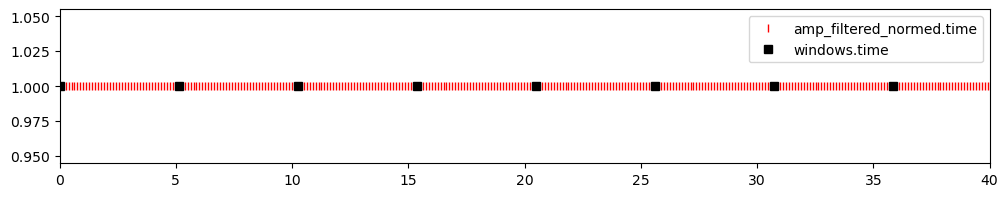

In [21]:
# This creates a new DataArray with a new dimension "window", that is window_len_samples large.
# The time dimension will contain the time coordinate of the first sample in the window.
# Setting the stride size to the same value as the window length will result in non-overlapping windows.
windows = amp_filtered_normed.rolling(time=window_len_samples).construct("window", stride=window_len_samples)

display(windows)

f,ax = p.subplots(1,1, figsize=(12,2))
p.plot(amp_filtered_normed.time, np.ones(len(amp_filtered_normed.time)), "r|", label="amp_filtered_normed.time")
p.plot(windows.time, np.ones(len(windows.time)), "ks", label="windows.time")
p.xlim(0,40)
p.legend();

### 4. Calculate the correlation coefficient for each window

The cross-correlation of two time series $X$ and $Y$ at time lag $\tau$ is:

$$ \rho_{XY}(\tau) = \frac{E \left[(X_t - \mu_X)\cdot (Y_{t+\tau} - \mu_Y) \right] }{\sigma_X \sigma_Y} $$

At time lag $\tau=0$ this reduces to:

$$ \rho_{XY}(\tau=0) = \frac{E \left[(X_t - \mu_X)\cdot (Y_{t} - \mu_Y) \right] }{\sigma_X \sigma_Y} = \frac{\frac{1}{N}\left(\sum_{t=t_1}^{t_2}(X_t - \mu_X)\cdot (Y_{t} - \mu_Y) \right) }{\sigma_X \sigma_Y}.$$

This is here computed over the time window $[t_1, t_2] $ of length $N$. The standard deviations $\sigma_X$ and $\sigma_X$ are calculated over the same time windows. The time series $X$ and $Y$ denote the two different wavelengths.

In [22]:
sci = (windows - windows.mean("window")).prod("wavelength").sum("window") / window_len_samples
sci /= windows.std("window").prod("wavelength")
display(sci)

Magnitude,[[inf 0.6894065095604274 0.621494086080535 ... 0.49133142071856617 0.249417183533184 0.554367367385543] [inf 0.7024883907718757 0.8253381076834428 ... 0.6859174705990052 0.7476637198371258 0.693473715726748] [inf 0.6943981096332187 0.47410822712497924 ... 0.6645215759723668 0.5913318798022112 0.574295507520571] ... [inf 0.9498508493274833 0.9337863545698755 ... 0.9522147509649724 0.8887917226841386 0.9430712599726605] [inf 0.9771623130258918 0.9783411218353902 ... 0.9651498687617033 0.9769248001104404 0.9547897549616838] [inf 0.9608223552577718 0.9646394985403904 ... 0.947870296737401 0.9338978159999929 0.9169020012920773]]
Units,dimensionless


### 5. Illustrate heat maps of SCIs for the whole recording and all channels

In [23]:
colors = ["black", "#DC3220", "#5D3A9B", "#0C7BDC"]
nodes = [0.0, 0.75, 0.751, 1.0]
sci_cmap = LinearSegmentedColormap.from_list("sci_cmap", list(zip(nodes,colors)))
sci_binary_cmap = LinearSegmentedColormap.from_list("sci_binary_cmap", list(zip([0,0.5,0.5,1],["#DC3220","#DC3220","#0C7BDC","#0C7BDC"])))

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:302: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


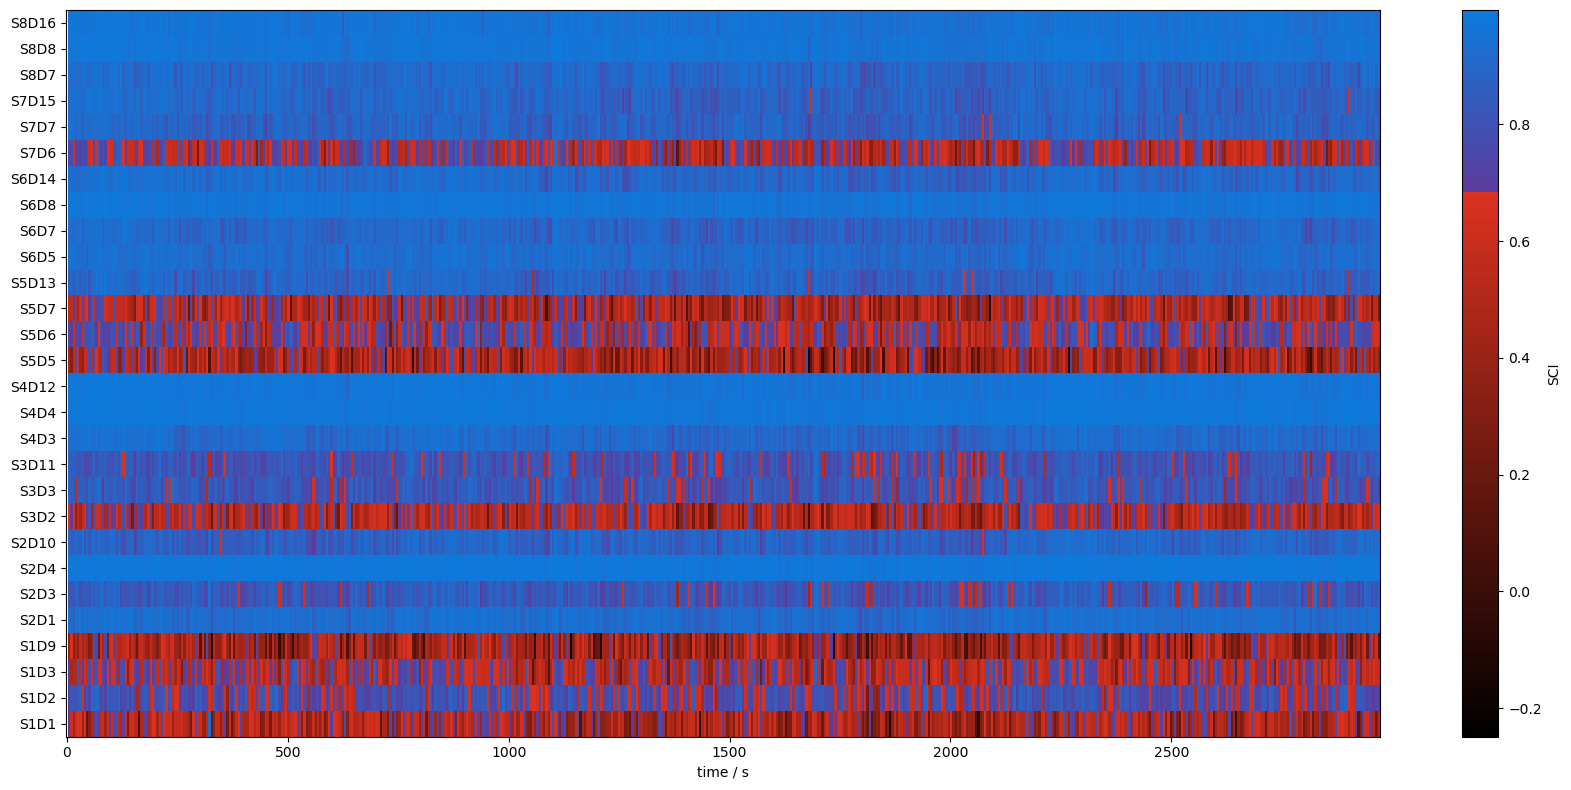

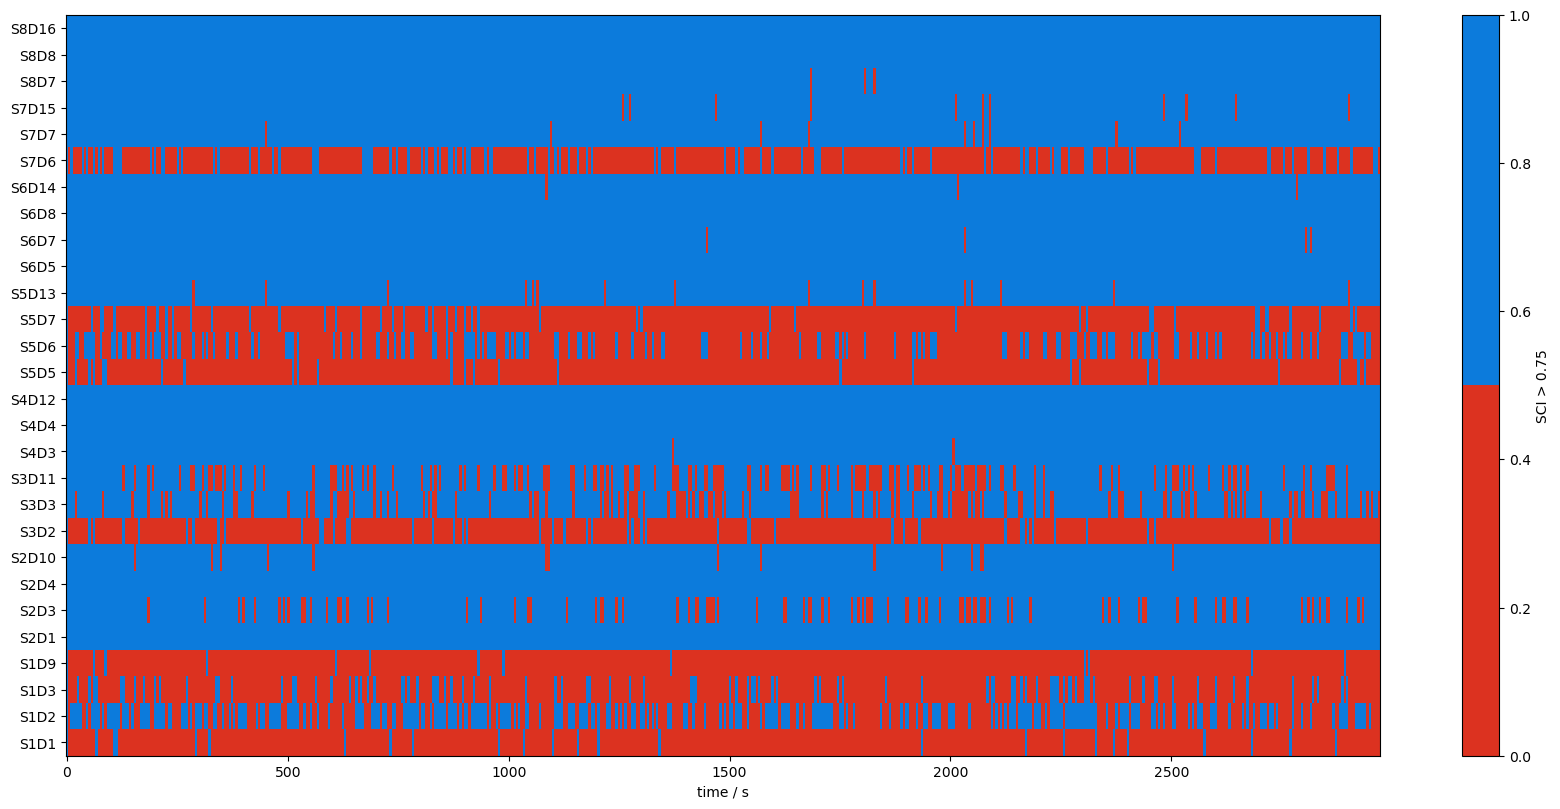

In [24]:
f,ax = p.subplots(1,1,figsize=(17,8))

m = ax.pcolormesh(sci.time, np.arange(len(sci.channel)), sci, shading="nearest", cmap=sci_cmap)
cb = p.colorbar(m, ax=ax)
cb.set_label("SCI")
ax.set_xlabel("time / s")
p.tight_layout()
ax.yaxis.set_ticks(np.arange(len(sci.channel)))
ax.yaxis.set_ticklabels(sci.channel.values);

f,ax = p.subplots(1,1,figsize=(17,8))

m = ax.pcolormesh(sci.time, np.arange(len(sci.channel)), sci>0.75, shading="nearest", cmap=sci_binary_cmap)
cb = p.colorbar(m, ax=ax)
p.tight_layout()
ax.yaxis.set_ticks(np.arange(len(sci.channel)))
ax.yaxis.set_ticklabels(sci.channel.values);
cb.set_label("SCI > 0.75")
ax.set_xlabel("time / s");


### 6. Inspect time courses of good and bad channels

S1D1: SCI <  0.75 of the times

S3D3: SCI < 0.75 around t=2000s

S3D11: SCI < 0.75 around t=2000s

S6D5: SCI > 0.75 for all samples

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:302: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


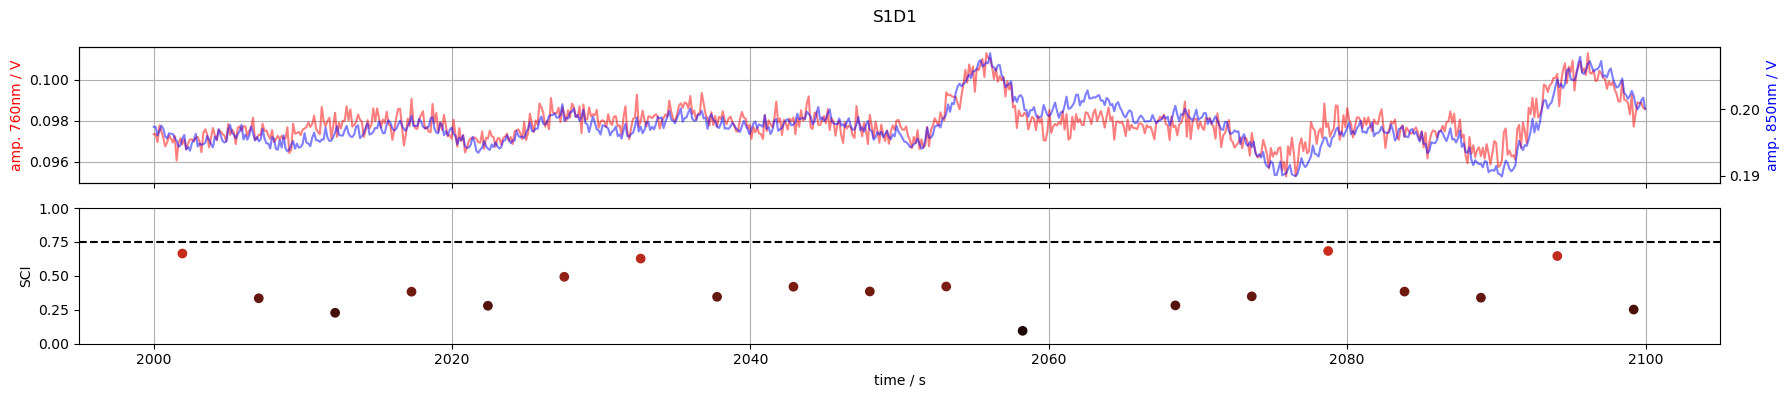

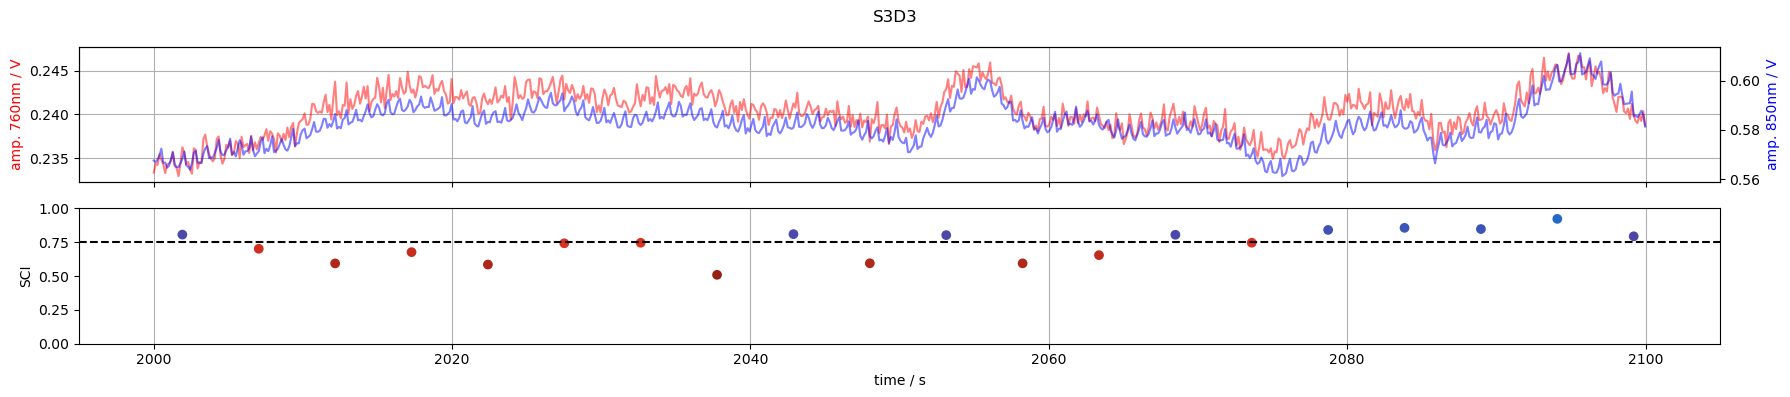

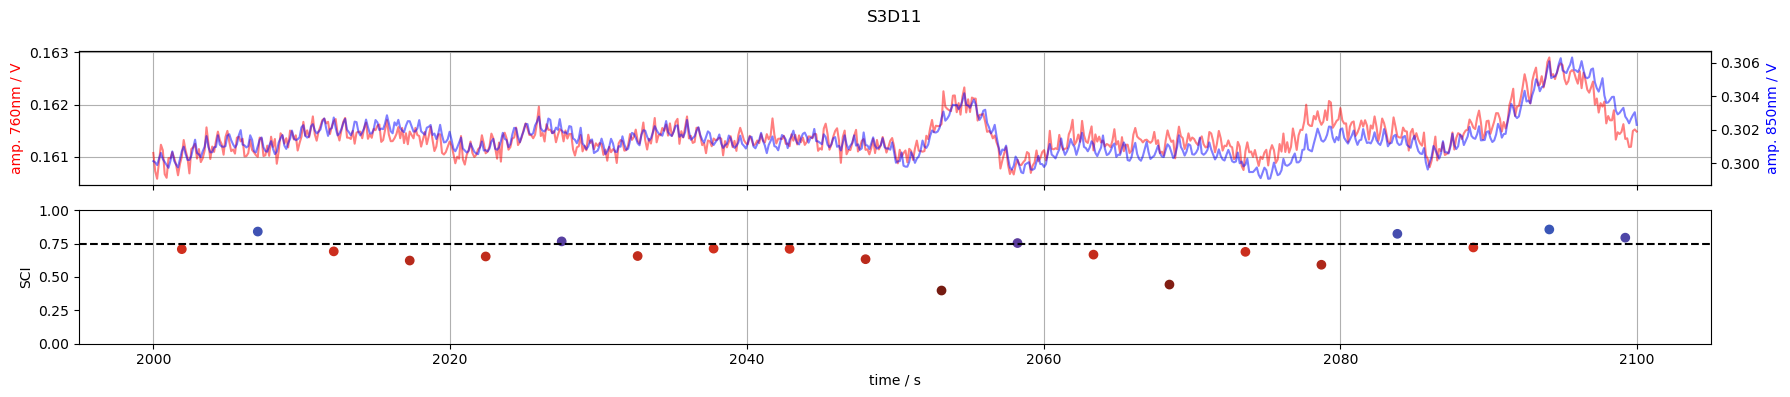

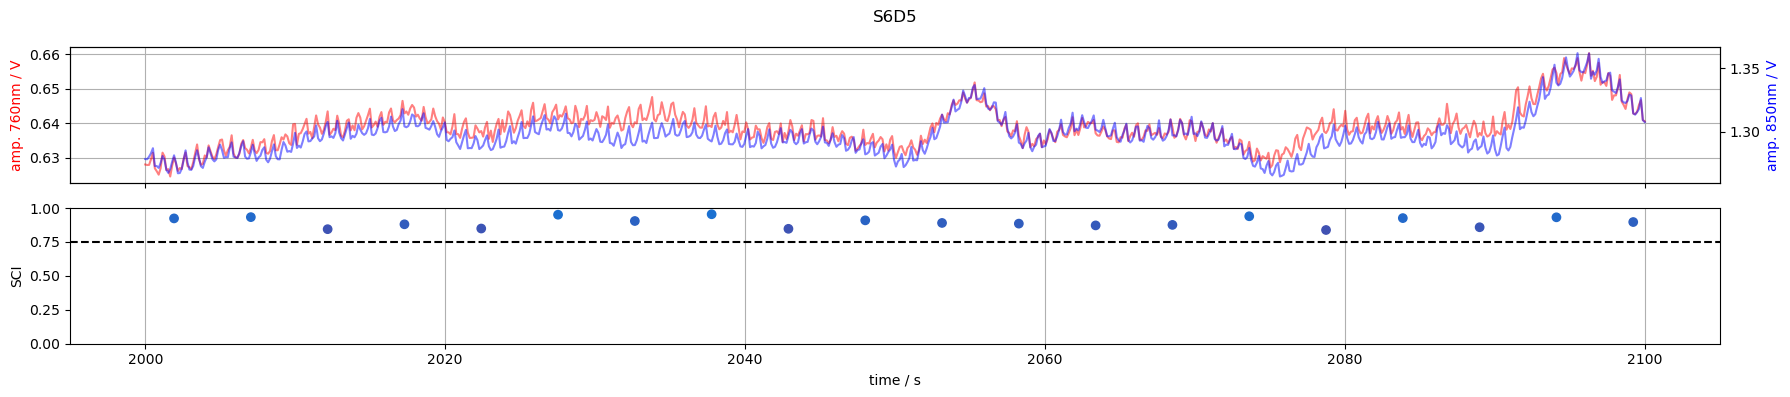

In [25]:
for channel in ["S1D1", "S3D3", "S3D11", "S6D5"]:
    tmin, tmax  = 2000, 2100
    f,ax = p.subplots(2,1, figsize=(18,4), sharex=True)

    m = (tmin <= rec["amp"].time) & (rec["amp"].time <= tmax)
    ax[0].plot(rec["amp"].time[m], rec["amp"].sel(channel=channel, wavelength=760, time=m), "r-", alpha=.5)
    ax[0].set_ylabel("amp. 760nm / V", color="r")
    ax2 =ax[0].twinx()
    ax2.plot(rec["amp"].time[m], rec["amp"].sel(channel=channel, wavelength=850, time = m), "b-", alpha=.5)
    ax2.set_ylabel("amp. 850nm / V", color="b")

    m = (tmin <= sci.time) & (sci.time <= tmax)
    ax[1].scatter(sci.time[m], sci.sel(channel=channel, time=m), c=sci_cmap(sci.sel(channel=channel, time=m)))
    ax[1].set_ylabel("SCI")
    ax[1].set_xlabel("time / s")
    ax[1].axhline(0.75, c="k", ls="--")
    ax[1].set_ylim(0,1)

    ax[0].grid(1)
    ax[1].grid(axis="x")

    f.suptitle(channel)
    f.set_tight_layout(True)

### 7. Calculate a quality mask for each sample of the recording 

raw amplitude array has 23239 values in the time dimension.
SCI has 581 values in the time dimension.
qmask has 23239 values in the time dimension.


(500.0, 520.0)

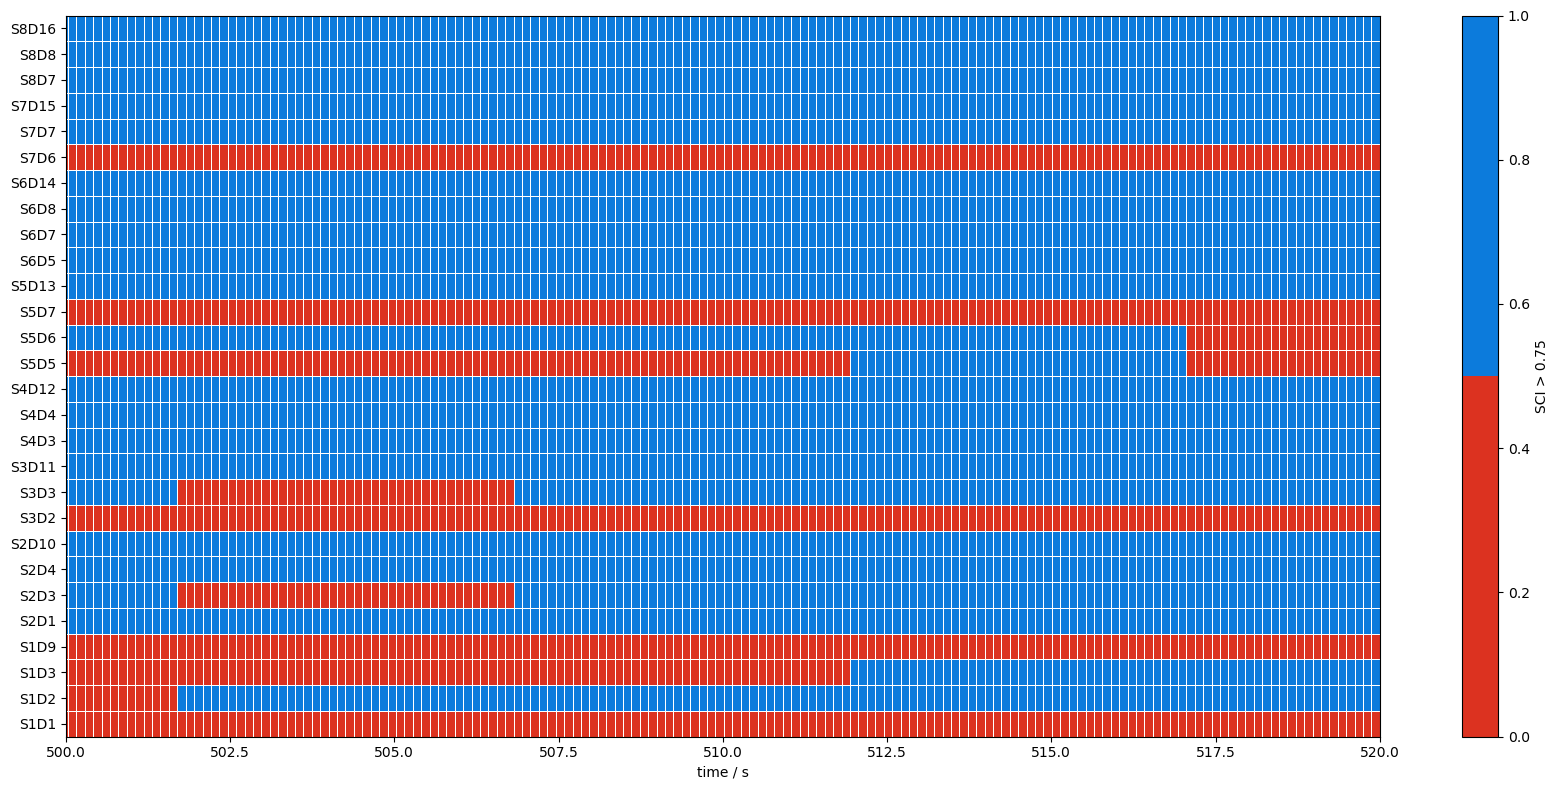

In [26]:
# sci.time coordinates contain the time of the first sample of each window.
# Use these as bin edges and calculate for each sample to which window it belongs.
# Subtract one from the indices returned by np.digitize as 0 denotes the underflow bin.
window_indices = np.digitize(rec["amp"].time, sci.time) - 1

# To obtain a quality mask for each sample we can threshold the sci array and then
# inflate it along the time dimension from n_windows values to n_samples: 
qmask = (sci > 0.75)[:, window_indices]
qmask["time"] = rec["amp"].time # carry over time coordinates from original array

print(f'raw amplitude array has {len(rec["amp"].time)} values in the time dimension.')
print(f'SCI has {len(sci.time)} values in the time dimension.')
print(f'qmask has {len(qmask.time)} values in the time dimension.')

f,ax = p.subplots(1,1,figsize=(17,8))
m = ax.pcolormesh(
    qmask.time, 
    np.arange(len(qmask.channel)), 
    qmask, 
    shading="nearest", 
    cmap=sci_binary_cmap,
    edgecolors="w",
    linewidths=0.5)
cb = p.colorbar(m, ax=ax)
cb.set_label("SCI > 0.75")
ax.set_xlabel("time / s")
p.tight_layout()
ax.yaxis.set_ticks(np.arange(len(qmask.channel)))
ax.yaxis.set_ticklabels(qmask.channel.values);
ax.set_xlim(500,520)
